## Machine Learning Intern Assessment Assignment

Objective is to develop a machine learning model to predict customer churn based on historical customer data. You will follow a typical machine learning project pipeline, from data preprocessing to model deployment.

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import datetime

In [2]:
# capturing the begining time of the notebook
start_time = datetime.datetime.now()

In [3]:
# removing all warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading data
churn_data = pd.read_excel('customer_churn_large_dataset.xlsx', index_col = 'CustomerID')
churn_data.head()

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,,
1.0,Customer_1,63.0,Male,Los Angeles,17.0,73.36,236.0,0.0
2.0,Customer_2,62.0,Female,New York,1.0,48.76,172.0,0.0
3.0,Customer_3,24.0,Female,Los Angeles,5.0,85.47,460.0,0.0
4.0,Customer_4,36.0,Female,Miami,3.0,97.94,297.0,1.0
5.0,Customer_5,46.0,Female,Miami,19.0,58.14,266.0,0.0


The column "Name" is not required for analysis.

In [5]:
# removing unnecessary column
data = churn_data.drop('Name', axis = 1)

In [6]:
# viewing data
data.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,
1.0,63.0,Male,Los Angeles,17.0,73.36,236.0,0.0
2.0,62.0,Female,New York,1.0,48.76,172.0,0.0
3.0,24.0,Female,Los Angeles,5.0,85.47,460.0,0.0
4.0,36.0,Female,Miami,3.0,97.94,297.0,1.0
5.0,46.0,Female,Miami,19.0,58.14,266.0,0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 100000 entries, 1.0 to 100000.0
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         100000 non-null  float64
 1   Gender                      100000 non-null  object 
 2   Location                    100000 non-null  object 
 3   Subscription_Length_Months  100000 non-null  float64
 4   Monthly_Bill                100000 non-null  float64
 5   Total_Usage_GB              100000 non-null  float64
 6   Churn                       100000 non-null  float64
dtypes: float64(5), object(2)
memory usage: 6.1+ MB


In [8]:
data.describe()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,44.027020,12.490100,65.053197,274.393650,0.497790
std,15.280283,6.926461,20.230696,130.463063,0.499998
min,18.000000,1.000000,30.000000,50.000000,0.000000
25%,31.000000,6.000000,47.540000,161.000000,0.000000
50%,44.000000,12.000000,65.010000,274.000000,0.000000
75%,57.000000,19.000000,82.640000,387.000000,1.000000
max,70.000000,24.000000,100.000000,500.000000,1.000000


In [9]:
data.isnull().sum()

Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

The data seems clean.

## Data Visualization
We will use different data visualization techniques to delve deeper into the data.

### Pair plot

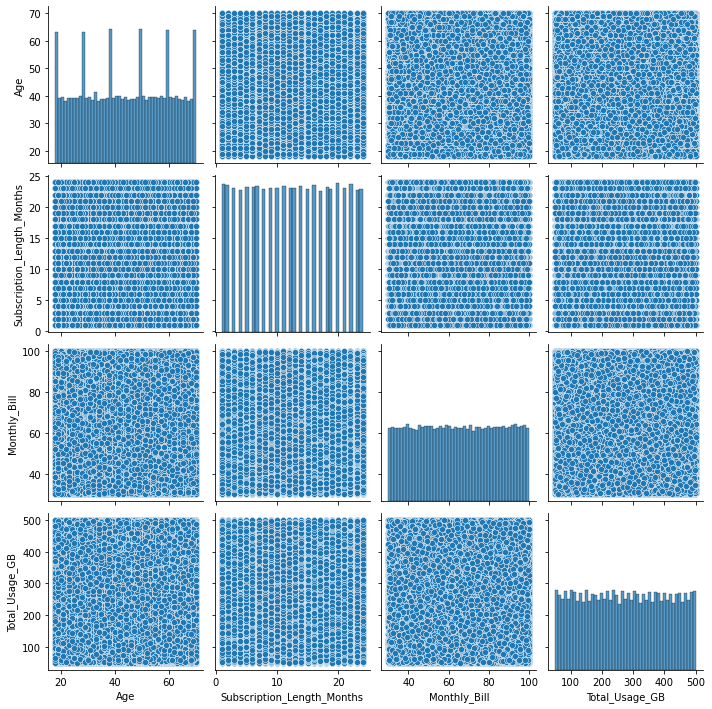

In [10]:
# using pairplot to check the relation between each column
ax = sns.pairplot(data=data[['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']])

The data very evenly scattered and there seems to be no apparent trend going on among any columns.

### Box plots

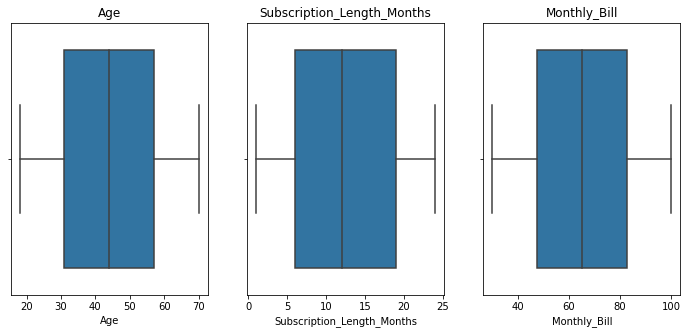

In [11]:
# using box plots to check for outliers
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

sns.boxplot(x=data['Age'], ax=ax[0])
sns.boxplot(x=data['Subscription_Length_Months'], ax=ax[1])
sns.boxplot(x=data['Monthly_Bill'], ax=ax[2])

ax[0].set_title('Age')
ax[1].set_title('Subscription_Length_Months')
ax[2].set_title('Monthly_Bill')

plt.show()

No outliers.

### Pie Chart

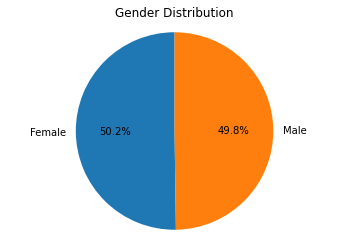

In [12]:
# using pie chart to check Gender distribution in the data
gender_counts = data['Gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Gender Distribution')
plt.show()

The Genders are almost equally divided.

## Data preprocessing

One hot encoding of categorical columns and splitting the data in train and test sets

In [13]:
# one-hot encoding
one_hot = pd.get_dummies(data['Location'], prefix='Location', prefix_sep='_', drop_first = True)
data = pd.concat([data, one_hot], axis=1)
data = data.drop('Location', axis=1)
data['Gender'] = data['Gender'].replace({'Male':0, 'Female':1})

In [14]:
# train & test split
X = data.drop('Churn', axis = 1)
y = data.Churn

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1)

## Building ML models

Building Logistic Regression, Random Forest Classifier, and LightBGM Classifier

### Logistic Regression

In [15]:
# Finding the best parameters for Logistic Regression

base_lr_model = LogisticRegression()

params_grid = {'penalty': ['l1', 'l2', 'none'],
            'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
            'max_iter': [100, 200, 300],
            'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(estimator = base_lr_model, param_grid = params_grid, cv=2, scoring='accuracy')
best_lr_model = grid.fit(X_train, y_train)

In [16]:
# Getting best parameters

best_penalty = best_lr_model.best_params_['penalty']
best_solver = best_lr_model.best_params_['solver']
best_max_iter = best_lr_model.best_params_['max_iter']
best_C = best_lr_model.best_params_['C']
accuracy = accuracy_score(y_val, best_lr_model.predict(X_val))

print("Best Penalty:", best_penalty)
print("Best Solver:", best_solver)
print("Best Max Iterations:", best_max_iter)
print("Best C:", best_C)
print("Validation Accuracy with Best Model:", accuracy)

Best Penalty: l2
Best Solver: lbfgs
Best Max Iterations: 100
Best C: 0.01
Validation Accuracy with Best Model: 0.5018666666666667


In [17]:
# Finding the best parameters for Random Forest Classifier

base_rf_model = RandomForestClassifier(random_state = 1)
params_grid = {'n_estimators': np.arange(50, 300, 50), 'max_depth': np.arange(2, 8, 1)}
grid = GridSearchCV(estimator = base_rf_model, param_grid = params_grid, scoring = 'roc_auc', cv = 2)
best_rf_model = grid.fit(X_train, y_train)

In [18]:
# Getting best parameters

best_n_estimators = grid.best_params_['n_estimators']
best_max_depth = grid.best_params_['max_depth']
accuracy = best_rf_model.score(X_val, y_val)
best_rf_score = best_rf_model.best_score_

print("Best Test Accuracy:", best_rf_score)
print("Validation Accuracy with Best Model:", accuracy)
print('The optimal value of n_estimators is', best_n_estimators)
print('The optimal value of max_depth is', best_max_depth)

Best Test Accuracy: 0.5036877715026731
Validation Accuracy with Best Model: 0.5052466177069967
The optimal value of n_estimators is 100
The optimal value of max_depth is 7


In [19]:
# Finding the best parameters for LightBGM Classifier

base_gbt_model = LGBMClassifier(random_state = 0)
params_grid = {'n_estimators': np.arange(50, 300, 50),
              'max_depth': np.arange(2, 8, 1),
              'learning_rate': np.arange(0.005, 0.03, 0.005)}
grid = GridSearchCV(estimator = base_gbt_model, param_grid = params_grid, scoring = 'roc_auc', cv = 2)
best_gbt_model = grid.fit(X_train, y_train)

In [20]:
# Getting best parameters

best_n_estimators = grid.best_params_['n_estimators']
best_max_depth = grid.best_params_['max_depth']
best_learning_rate = grid.best_params_['learning_rate']
accuracy = best_gbt_model.score(X_val, y_val)
best_gbt_score = best_gbt_model.best_score_

print("Best Test Accuracy:", best_gbt_score)
print("Validation Accuracy with Best Model:", accuracy)
print('The optimal value of n_estimators is', best_n_estimators)
print('The optimal value of learning_rate is', best_learning_rate)
print('The optimal value of max_depth is', best_max_depth)

Best Test Accuracy: 0.5051846555762606
Validation Accuracy with Best Model: 0.5058224220058056
The optimal value of n_estimators is 250
The optimal value of learning_rate is 0.025
The optimal value of max_depth is 7


## Model performance metrics

Creating Confusion Matrix, Precision-Recall Curve and ROC-AUC curve. Getting Accuracies, F1 scores and Recall Values.

### Confusion Matrix

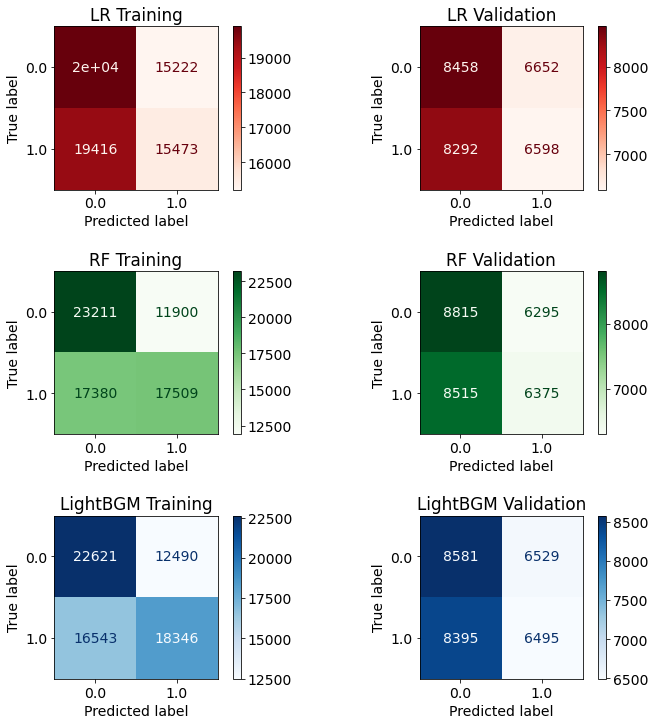

In [21]:
# Creating Confusion Matrix for all the models

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3, 2, figsize = (12, 12))
plt.subplots_adjust(hspace=0.5)

ConfusionMatrixDisplay.from_estimator(best_lr_model, X_train, y_train, cmap = plt.cm.Reds, ax = ax[0][0])
ConfusionMatrixDisplay.from_estimator(best_lr_model, X_val, y_val, cmap = plt.cm.Reds, ax = ax[0][1])
ax[0][0].set_title('LR Training')
ax[0][1].set_title('LR Validation');

ConfusionMatrixDisplay.from_estimator(best_rf_model, X_train, y_train, cmap = plt.cm.Greens, ax = ax[1][0])
ConfusionMatrixDisplay.from_estimator(best_rf_model, X_val, y_val, cmap = plt.cm.Greens, ax = ax[1][1])
ax[1][0].set_title('RF Training')
ax[1][1].set_title('RF Validation');

ConfusionMatrixDisplay.from_estimator(best_gbt_model, X_train, y_train, cmap = plt.cm.Blues, ax = ax[2][0])
ConfusionMatrixDisplay.from_estimator(best_gbt_model, X_val, y_val, cmap = plt.cm.Blues, ax = ax[2][1])
ax[2][0].set_title('LightBGM Training')
ax[2][1].set_title('LightBGM Validation');

### Performance Metrics

In [22]:
# Getting Performances Metrics for all the models

models = [best_lr_model, best_rf_model, best_gbt_model]
y_preds = [model.predict(X_val) for model in models]
accuracies = [accuracy_score(y_val, y_pred) for y_pred in y_preds]
f1_scores = [f1_score(y_val, y_pred) for y_pred in y_preds]
recall_scores_pos = [recall_score(y_val, y_pred, pos_label = 1) for y_pred in y_preds]
recall_scores_neg = [recall_score(y_val, y_pred, pos_label = 0) for y_pred in y_preds]
val_accuracies = [model.score(X_val, y_val) for model in models]

model_names = ['best_lr_model', 'best_rf_model', 'best_gbt_model']
performance_df = pd.DataFrame({'Accuracies':accuracies,
                              'F1 Scores':f1_scores,
                              'Recall Scores (Positive)':recall_scores_pos,
                              'Recall Scores (Negative)':recall_scores_neg, 
                              'Valication Accuracies':val_accuracies},
                              index = model_names)

In [23]:
# Viewing the results

performance_df

,Accuracies,F1 Scores,Recall Scores (Positive),Recall Scores (Negative),Valication Accuracies
best_lr_model,0.501867,0.468941,0.443116,0.559762,0.501867
best_rf_model,0.506333,0.462627,0.428140,0.583388,0.505247
best_gbt_model,0.502533,0.465358,0.436199,0.567902,0.505822


### ROC-AUC Curves

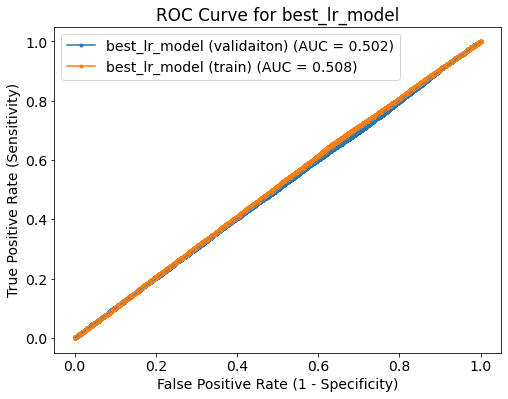

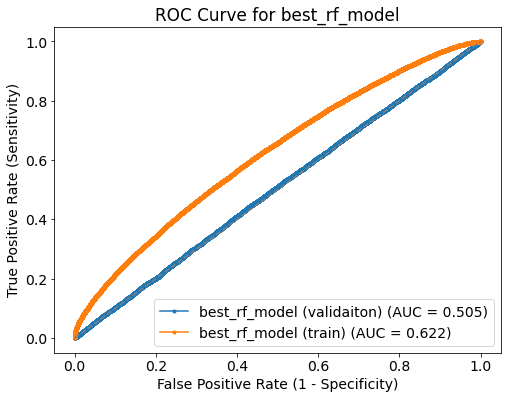

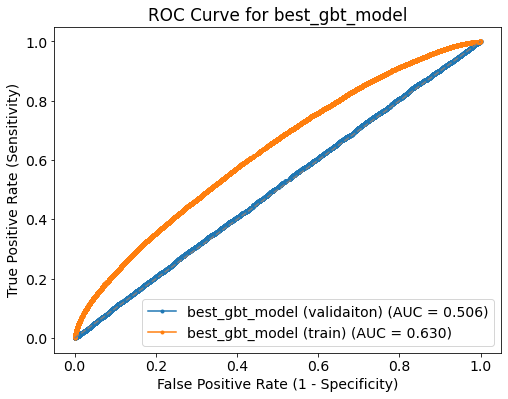

In [24]:
# Creating ROC-AUC Curves for all the models

for model, model_name in zip(models, model_names):
    
    plt.figure(figsize=(8, 6))
    
    probs_val = model.predict_proba(X_val)[:, 1]
    probs_train = model.predict_proba(X_train)[:, 1]
    
    auc_val = roc_auc_score(y_val, probs_val)
    auc_train = roc_auc_score(y_train, probs_train)
    
    fpr_val, tpr_val, _ = roc_curve(y_val, probs_val)
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    
    plt.plot(fpr_val, tpr_val, marker='.', label=f'{model_name} (validaiton) (AUC = {auc_val:.3f})')
    plt.plot(fpr_train, tpr_train, marker='.', label=f'{model_name} (train) (AUC = {auc_train:.3f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    
    plt.legend()
    plt.title(f'ROC Curve for {model_name}')
    
    plt.show()

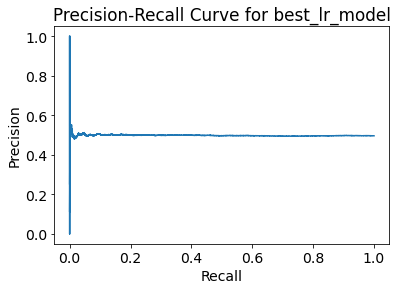

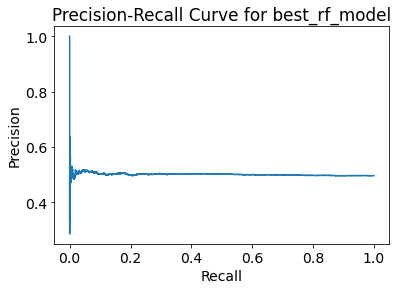

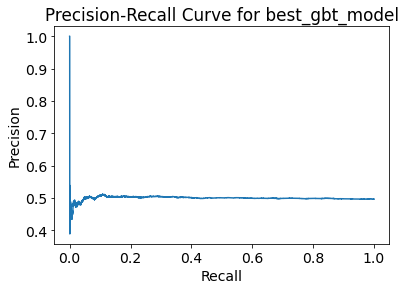

In [25]:
# Creating Precision-Recall Curve

for model, model_name in zip(models, model_names):
    
    probs_val = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, probs_val)

    plt.plot(recall, precision)
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.ylabel('Precision')
    plt.xlabel('Recall')

    plt.show()

## Neural Network

Creating FCFFN for churn prediction

In [26]:
# defining neural network funciton

def create_nn(n_hidden=1, n_neurons=8,
              activation_function='sigmoid',
              loss_function='binary_crossentropy',
              learning_rate_value=0.001):
    nn = Sequential()
    nn.add(Dense(units=n_neurons,
                 input_shape=(9,),
                 activation=activation_function))
    for n_hid in np.arange(1, n_hidden, 1):
        nn.add(Dense(units=n_neurons,
                     activation=activation_function))
    nn.add(Dense(units=1, activation='sigmoid'))
    nn.compile(loss=loss_function,
               metrics=['accuracy'],
               optimizer=RMSprop(learning_rate=learning_rate_value))

    return nn

In [27]:
# standardizing the data splitting into train and test

scaler = StandardScaler()
data[['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']] = scaler.fit_transform(data[['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']])

X = data.drop('Churn', axis = 1)
y = data.Churn

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (80000, 9)
y_train shape: (80000,)


In [29]:
# tuning hyperparameters

base_grid_model = KerasClassifier(build_fn = create_nn)

parameters_grid = {'n_hidden': [1, 2],
                   'n_neurons':[8, 16],
                   'batch_size': [64, 128],
                   'activation_function': ['sigmoid', 'relu'],
                   'learning_rate_value': [0.001, 0.01]}

grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    cv = 2,
                    verbose = 4)

grid_model = grid.fit(X_train, y_train, epochs = 10)

best_n_hidden = grid_model.best_params_['n_hidden']
best_n_neurons = grid_model.best_params_['n_neurons']
best_batch_size = grid_model.best_params_['batch_size']
best_activation = grid_model.best_params_['activation_function']
best_learning_rate = grid_model.best_params_['learning_rate_value']
best_accuracy = grid_model.best_score_

print('The optimal value of n hidden is', best_n_hidden)
print('The optimal value of n neurons is', best_n_neurons)
print('The optimal value of batch size is', best_batch_size)
print('The optimal value of activation function is', best_activation)
print('The optimal value of learning rate is', best_learning_rate)
print('The accuracy of the model with these optimal parameters is ', best_accuracy)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6978 - accuracy: 0.4969
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5027
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5059
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5063
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5070
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5084
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5082
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5059
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5060
Epoch 10/10
625/625 [==================

625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5072
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5036
Epoch 10/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6933 - accuracy: 0.5041
[CV 1/2] END activation_function=sigmoid, batch_size=64, learning_rate_value=0.001, n_hidden=2, n_neurons=16;, score=0.504 total time=  12.3s
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6941 - accuracy: 0.4972
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5015
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5001
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.4972
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.4980
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - 

625/625 [==============================] - 1s 2ms/step - loss: 0.6940 - accuracy: 0.5018
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6940 - accuracy: 0.5004
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.4992
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5027
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5027
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.4967
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5023
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.4980
[CV 2/2] END activation_function=sigmoid, batch_size=64, learning_rate_value=0.01, n_hidden=2, n_neurons=8;, score=0.498 total time=  13.1s
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - lo

313/313 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5044
[CV 2/2] END activation_function=sigmoid, batch_size=128, learning_rate_value=0.001, n_hidden=1, n_neurons=16;, score=0.504 total time=   6.6s
Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6968 - accuracy: 0.5016
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5038
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5058
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5008
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5024
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5066
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5052
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - 

313/313 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5037
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.5066
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5005
Epoch 9/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5020
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.4993
[CV 1/2] END activation_function=sigmoid, batch_size=128, learning_rate_value=0.01, n_hidden=1, n_neurons=16;, score=0.499 total time=   7.5s
Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6951 - accuracy: 0.4962
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6952 - accuracy: 0.4992
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6949 - accuracy: 0.4970
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - 

625/625 [==============================] - 2s 2ms/step - loss: 0.7083 - accuracy: 0.5006
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6940 - accuracy: 0.5016
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5006
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5023
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5058
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5038
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5061
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5057
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5056
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5031
[CV 2/2] E

625/625 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.5170
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.5026
[CV 2/2] END activation_function=relu, batch_size=64, learning_rate_value=0.001, n_hidden=2, n_neurons=16;, score=0.503 total time=  13.8s
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6965 - accuracy: 0.4998
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5030
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5055
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5071
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5028
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5046
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - los

625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5011
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5025
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.4956
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5030
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5005
[CV 1/2] END activation_function=relu, batch_size=64, learning_rate_value=0.01, n_hidden=2, n_neurons=16;, score=0.501 total time=  14.0s
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6945 - accuracy: 0.4970
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.4981
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss

313/313 [==============================] - 1s 2ms/step - loss: 0.6956 - accuracy: 0.5001
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5030
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5062
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5091
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5088
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5113
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5143
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5120
Epoch 9/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5123
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5005
[CV 2/2] E

313/313 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5038
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6945 - accuracy: 0.4990
[CV 2/2] END activation_function=relu, batch_size=128, learning_rate_value=0.01, n_hidden=1, n_neurons=16;, score=0.499 total time=   7.1s
Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6940 - accuracy: 0.5016
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5022
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.4995
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5043
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5085
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5053
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - los

In [30]:
# creating FCFFN with optimal values obtained from grid search

nn = create_nn(n_hidden = best_n_hidden,
               n_neurons = best_n_neurons,
               activation_function = best_activation,
               loss_function = 'binary_crossentropy',
               learning_rate_value = best_learning_rate)

nn.summary()
print('\n')
nn_history = nn.fit(X_train, y_train, batch_size = best_batch_size, validation_split = 0.2, epochs = 25)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 16)                160       
                                                                 
 dense_163 (Dense)           (None, 1)                 17        
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


Epoch 1/25
500/500 [==============================] - 2s 3ms/step - loss: 0.6946 - accuracy: 0.4990 - val_loss: 0.6936 - val_accuracy: 0.4939
Epoch 2/25
500/500 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 3/25
500/500 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6933 - val_accuracy: 0.5009
Epoch 4/25
500/500 [===

In [31]:
# evaluating the performance of FCFFN with validation set

performance_test = nn.evaluate(X_val, y_val)

print('The loss value of the model on the test data is {}'.format(performance_test[0]))
print('The accuracy of the model on the test data is {}'.format(performance_test[1]))

625/625 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5002
The loss value of the model on the test data is 0.6933818459510803
The accuracy of the model on the test data is 0.500249981880188


In [32]:
# capturing the ending time of the notebook
end_time = datetime.datetime.now()

In [33]:
#checking total time taken by the notebook
end_time - start_time

datetime.timedelta(seconds=1488, microseconds=694671)

# Summary

- Started with loading and getting an overview of the data.
- There was nothing to clean as the data had no empty values or any outliers.
- Performed Data Visulization using different matplotlib and seaborn texhniques.
- The data seemed to be very evenly distributed with no apparent trend going on.
- Created different ML models, like, Logistic Regression, Random Forest Classifier, and LightBGM.
- Tuned hyperparameters to get the best accuracies.
- Check other performance metrics like accuracies, f1 scores, and recall scores.
- Created ROC-AUC curves and Confusion Matrix for each model.
- Created an FCFFN.
- Tuned the Hyperpermaters.
- Evaluated its performance on the validaiton dataset.